In [5]:
import pandas as pd
import numpy as np
import pickle

from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from dtreeviz.trees import dtreeviz # will be used for tree visualization
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})


In [28]:
training_data = pd.read_csv('/home/ec2-user/capstone/broadband-capstone/data/current_data/train_3.csv')
test_data = pd.read_csv('/home/ec2-user/capstone/broadband-capstone/data/current_data/test_3.csv')

### Modeling

In [3]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [4]:
poverty_rate_train = np.array(training_data['poverty_rate'])
poverty_rate_test = np.array(test_data['poverty_rate'])

def poverty_rf_model(train_df, 
                     test_df, 
                     variable_list,
                     poverty_rate_train = poverty_rate_train,  
                     poverty_rate_test = poverty_rate_test):
    train_variables = np.array(train_df[variable_list])
    test_variables = np.array(test_df[variable_list])
    
    model = RandomForestRegressor(n_estimators = 100, random_state = 42).fit(train_variables, poverty_rate_train)
    predicted = model.predict(test_variables)
    
    regression_results(poverty_rate_test, predicted)
    return pd.DataFrame(model.feature_importances_, index = variable_list).sort_values(by=0,ascending = False)


In [5]:
def random_forest_with_tuning(variable_list, feature_importance=True):
    #With tuning
    regressor = RandomForestRegressor(n_estimators = 1000, 
                                      min_samples_split = 10, 
                                      min_samples_leaf = 2, 
                                      max_features = 'auto',
                                      max_depth = 10,
                                      bootstrap = True)

    regressor.fit(training_data[variable_list],  np.array(training_data['poverty_rate']))
    predictions = regressor.predict(test_data[variable_list])
    regression_results(np.array(test_data['poverty_rate']), predictions)
    
    if feature_importance:
        return pd.DataFrame(regressor.feature_importances_, index = variable_list).sort_values(by=0,ascending = False)
    else:
        return regressor


#### Only key broadband variables

In [7]:
key_vars = ['pct_internet', 
            'pct_only_cellular', 
            'pct_computing_device_no_internet', 
            'pct_internet_broadband_satellite', 
            'pct_computing_device_with_broadband']


In [15]:
#Without tuning
poverty_rf_model(training_data, test_data, key_vars)

explained_variance:  0.4911
r2:  0.4903
MAE:  5.6872
MSE:  61.065
RMSE:  7.8144


,0
pct_computing_device_with_broadband,0.307379
pct_internet,0.296803
pct_only_cellular,0.146818
pct_internet_broadband_satellite,0.137759
pct_computing_device_no_internet,0.111240


In [17]:
#Using tuning from last random forest notebook
regressor = RandomForestRegressor(n_estimators = 1000, 
                                  min_samples_split = 10, 
                                  min_samples_leaf = 2, 
                                  max_features = 'auto',
                                  max_depth = 10,
                                  bootstrap = True)

regressor.fit(training_data[key_vars],  np.array(training_data['poverty_rate']))
predictions = regressor.predict(test_data[key_vars])
regression_results(np.array(test_data['poverty_rate']), predictions)

explained_variance:  0.5177
r2:  0.5176
MAE:  5.4917
MSE:  57.7992
RMSE:  7.6026


#### Broadband variable set 2

In [8]:
key_vars_2 = ['Ookla Median Download Speed (Mbps)', 
            'pct_internet', 
            'Wired_Provider_Count', 
            'pct_computing_device', 
            'pct_internet_broadband_any_type']



In [10]:
random_forest_with_tuning(key_vars_2)

explained_variance:  0.4585
r2:  0.4584
MAE:  5.8323
MSE:  64.8904
RMSE:  8.0555


,0
pct_internet,0.829212
Ookla Median Download Speed (Mbps),0.079720
pct_computing_device,0.048627
pct_internet_broadband_any_type,0.032151
Wired_Provider_Count,0.010290


#### Broadband variables set 1 + set 2

In [9]:
key_vars_3 = list(set(key_vars+key_vars_2))

In [14]:
random_forest_with_tuning(key_vars_3)

explained_variance:  0.5322
r2:  0.532
MAE:  5.3932
MSE:  56.0635
RMSE:  7.4876


,0
pct_internet,0.364152
pct_computing_device_with_broadband,0.348165
pct_only_cellular,0.098867
pct_internet_broadband_satellite,0.068568
Ookla Median Download Speed (Mbps),0.049481
pct_computing_device_no_internet,0.029593
pct_computing_device,0.022173
pct_internet_broadband_any_type,0.012265
Wired_Provider_Count,0.006735


#### Highest feature importance vars

In [10]:
highest_importance_vars = ['pct_internet', 
                          'pct_computing_device_with_broadband',
                          'median_age_overall', 
                          'pct_white', 
                          'employment_rate',
                          'pct_pop_20_to_24', 
                          'pct_pop_disability']

In [16]:
random_forest_with_tuning(highest_importance_vars)

explained_variance:  0.7278
r2:  0.7278
MAE:  4.162
MSE:  32.6127
RMSE:  5.7107


,0
pct_internet,0.237590
pct_computing_device_with_broadband,0.236271
median_age_overall,0.203032
pct_white,0.114038
employment_rate,0.099471
pct_pop_20_to_24,0.061016
pct_pop_disability,0.048581


#### Covariates

In [11]:
covariates = ['pct_hisp_latino', 
              'ruca_metro', 
              'ruca_micro', 
              'ruca_small_town', 
              'ruca_rural', 
              'pct_pop_foreign_born', 
              'pct_pop_disability']



In [20]:
random_forest_with_tuning(covariates)

explained_variance:  0.2757
r2:  0.2755
MAE:  6.6805
MSE:  86.794
RMSE:  9.3163


,0
pct_pop_disability,0.563411
pct_hisp_latino,0.297664
pct_pop_foreign_born,0.109052
ruca_metro,0.022477
ruca_micro,0.003780
ruca_rural,0.002443
ruca_small_town,0.001172


#### Covariates, broadband set 1, highest feature importance vars

In [12]:
set1 = covariates + key_vars + highest_importance_vars

In [23]:
random_forest_with_tuning(set1)

explained_variance:  0.7397
r2:  0.7397
MAE:  4.0856
MSE:  31.1856
RMSE:  5.5844


,0
median_age_overall,0.193650
pct_computing_device_with_broadband,0.119683
pct_internet,0.117858
pct_internet,0.115033
pct_computing_device_with_broadband,0.108151
pct_white,0.105332
employment_rate,0.093536
pct_pop_20_to_24,0.056238
pct_pop_disability,0.020111
pct_pop_disability,0.019754


#### Highest feature importance variables and highest broadband feature importance variables

In [13]:
highest_broadband_importance_vars = ['pct_only_cellular', 
                                     'pct_internet', 
                                     'pct_internet_broadband_satellite']

In [14]:
high_importance_vars = highest_importance_vars + highest_broadband_importance_vars

In [12]:
random_forest_with_tuning(high_importance_vars)

explained_variance:  0.7374
r2:  0.7374
MAE:  4.1018
MSE:  31.4625
RMSE:  5.6091


,0
pct_computing_device_with_broadband,0.228299
median_age_overall,0.196254
pct_internet,0.120986
pct_internet,0.115616
pct_white,0.108717
employment_rate,0.095937
pct_pop_20_to_24,0.057808
pct_pop_disability,0.041834
pct_only_cellular,0.018157
pct_internet_broadband_satellite,0.016394


#### Broadband set 1 + highest importance vars and highest broadband feature importance vars

In [15]:
high_importance_and_set_1 = high_importance_vars + key_vars

In [17]:
random_forest_with_tuning(high_importance_and_set_1)

explained_variance:  0.7371
r2:  0.737
MAE:  4.1063
MSE:  31.5043
RMSE:  5.6129


,0
median_age_overall,0.195522
pct_computing_device_with_broadband,0.113755
pct_computing_device_with_broadband,0.110440
pct_white,0.108352
employment_rate,0.095202
pct_internet,0.083486
pct_internet,0.078192
pct_internet,0.077608
pct_pop_20_to_24,0.057203
pct_pop_disability,0.041289


In [28]:
model = random_forest_with_tuning(high_importance_and_set_1, False)

explained_variance:  0.737
r2:  0.737
MAE:  4.1059
MSE:  31.5118
RMSE:  5.6135


In [30]:
pickle.dump(model, open('/home/ec2-user/capstone/broadband-capstone/models/poverty_rate_random_forest_3.pkl', 'wb'))

In [29]:
high_importance_and_set_1

['pct_internet',
 'pct_computing_device_with_broadband',
 'median_age_overall',
 'pct_white',
 'employment_rate',
 'pct_pop_20_to_24',
 'pct_pop_disability',
 'pct_only_cellular',
 'pct_internet',
 'pct_internet_broadband_satellite',
 'pct_internet',
 'pct_only_cellular',
 'pct_computing_device_no_internet',
 'pct_internet_broadband_satellite',
 'pct_computing_device_with_broadband']

#### Broadband set 2 + highest importance vars and highest broadband feature importance vars

In [16]:
high_importance_and_set_2 = list(set(high_importance_vars + key_vars_2))

In [16]:
feature_importances = random_forest_with_tuning(high_importance_and_set_2)

explained_variance:  0.738
r2:  0.7379
MAE:  4.1005
MSE:  31.3954
RMSE:  5.6032


In [21]:
feature_importances

,0
pct_computing_device_with_broadband,0.228976
pct_internet,0.226526
median_age_overall,0.194511
pct_white,0.106705
employment_rate,0.093917
pct_pop_20_to_24,0.056532
pct_pop_disability,0.039984
pct_only_cellular,0.016660
pct_internet_broadband_satellite,0.014249
pct_computing_device,0.009181


<AxesSubplot:title={'center':'RF Feature Importance - Poverty Rate'}>

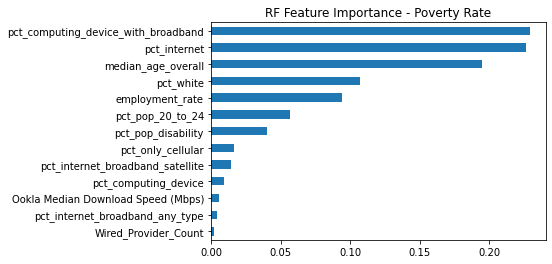

In [25]:
feature_importances.sort_values(by=0,ascending=True).plot.barh(title='RF Feature Importance - Poverty Rate', legend=False)

In [15]:
model = random_forest_with_tuning(high_importance_and_set_2, False)

explained_variance:  0.738
r2:  0.738
MAE:  4.0993
MSE:  31.392
RMSE:  5.6029


In [16]:
pickle.dump(model, open('/home/ec2-user/capstone/broadband-capstone/models/poverty_rate_random_forest_2.sav', 'wb'))

In [6]:
with open('/home/ec2-user/capstone/broadband-capstone/models/poverty_rate_random_forest_2.sav', 'rb') as f:
    poverty_model_random_forest = pickle.load(f)

In [17]:
high_importance_and_set_2

['pct_internet',
 'pct_internet_broadband_satellite',
 'pct_white',
 'pct_pop_disability',
 'pct_computing_device_with_broadband',
 'Ookla Median Download Speed (Mbps)',
 'employment_rate',
 'Wired_Provider_Count',
 'pct_computing_device',
 'median_age_overall',
 'pct_internet_broadband_any_type',
 'pct_pop_20_to_24',
 'pct_only_cellular']

In [22]:
poverty_model_random_forest.estimators_[0]

DecisionTreeRegressor(max_depth=10, max_features='auto', min_samples_leaf=2,
                      min_samples_split=10, random_state=1622754031)

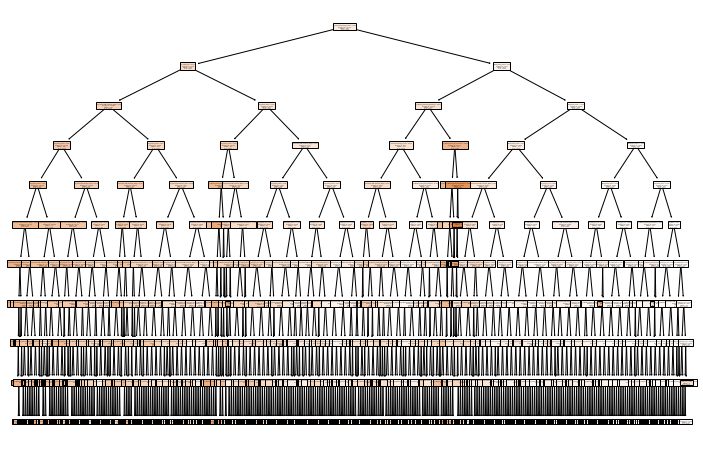

In [18]:
_ = tree.plot_tree(poverty_model_random_forest.estimators_[0], feature_names=high_importance_and_set_2, filled=True)

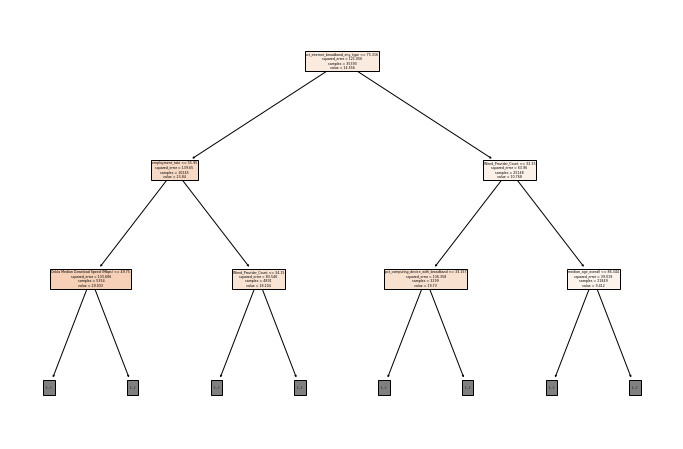

In [32]:
_ = tree.plot_tree(poverty_model_random_forest.estimators_[0], feature_names=high_importance_and_set_2, filled=True, max_depth=2)

